# Illicit Discharge Tracking - Instantaneous Point Source Analysis

This notebook provides a method to determine the location upstream where a possible illicit discharge occurred by only using downstream data. Conductivity data and flow information must be inputted. The program then calculates a dispersion coefficient with empirical equations or with predictor equations for streams where the dispersion coefficient has not yet been studied. The program produces a concentration curve from the observed conductivity data using a regression equation comparing concentrations of sodium chloride with electrical conductivity. The area under this observed concentration curve is multiplied by flowrate to estimate the mass of the substance. The observed concentration curve is then compared with a synthetic concentration curve computed by Taylor's Solution (Eq. 1) (Fischer, 1967; French, 1986, & Rutherford, 1994). $$C(x,t)=\frac{M}{A\sqrt{4πK_x t}}exp⁡[\frac{-(x-V_x t)^2}{(4K_x t)}] \;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\; (Eq. 1)$$  Several synthetic concentration curves are computed until the slope of the leading front is equal to the slope of the observed concentration curve. When the slopes are approximately equal, the synthetic concentration curve outputs an optimized distance, x, between the monitoring station and location upstream where the illicit source was discharged.<br />
<br />
This methodology works best when the user is investigating a uniform channel or stream. It has not yet been experimented with large streams or rivers; however, many studies have used Taylor's Solution and predictor equations to determine dispersion coefficients of rivers.
<br />
<br />

###### Populate Notebook with libraries

In [16]:
%pylab inline
%config InlineBackend.figure_format='retina' # hig-res plots for a Retina display
from scipy.integrate import odeint
from scipy.optimize import curve_fit
import pandas as pd
import statsmodels.formula.api as smf
import numpy as np
import os
os.chdir('/home/user/Tracer Data') # import working directory for conductivity data

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['diff']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Input Stream Characteristics

In [17]:
A1 = 1.0     # ft^2/s         Average cross-sectional area
Q1 = 0.5     # ft^3/s         Flow rate
W1 = 3       # ft             Average width
S = 0.0068   # ft/ft or m/m   Slope
#-------------------------------------------------------------------
U1 = Q1/A1   # ft/s           Average cross-sectional velocity
h1 = A1/W1   # ft             Average height of water

# Convert from US units to SI
ft_m = (30.48/100)
U = U1*ft_m       # m/s
A = A1*ft_m**2    # m^2
Q = Q1*ft_m**3    # m^3/s
h = h1*ft_m       # m
W = W1*ft_m       # m

#### Determine dispersion coefficient from empirical equations
Empirical equations are developed from flow data during tracer experiments. Equations 2 and 3 were developed for reach 1, a 300-ft uniform section of Webb Branch in Blacksburg, Virginia. If empirical equations are not present for the reach of interest, determine the dispersion coefficeint from predictor equations. $$K = 6.0966*Q^{0.7414} \;\;\;\;\;\;\; (Eq. 2) $$ $$ K = 7.5017*V_x^{0.9643} \;\;\;\;\;\;\; (Eq. 3)$$
where $V_x$ is in units of $ft/s$ and $K$ is in units of $ft^2/s$


In [18]:
# Empirical equations derived from various flow conditions on Reach 1
KQ1 = 6.0966*Q1**(0.7414)  # ft^2/s (for reach 1 near Edge apartments)
KU1 = 7.5017*U1**(0.9643)  # ft^2/s (for reach 1 near Edge apartments)
KQ = KQ1*ft_m**2           # m^2/s
KU = KU1*ft_m**2           # m^2/s

#### Determine dispersion coefficient from predictor equations
Predictor equations are simple, practical formulas to determine a dispersion coefficients without performing tracer experiments; however, they can be inaccurate. Dozens of predictor equations have been published, but for reach 1, "Iwasa & Aya 1991" (Eq. 4) and "Koussis & Rodríguez-Mirasol 1998" (Eq. 5) performed the best when comapred with the observed dispersion coefficient. For other predictor equations or selecting a dispersion coefficient from previous studies, "Rieckermann et al. 2005" and "Wallis and Manson. 2014" are helpful resources referenced following the program's final outputs. 
$$K_I = 2*\frac{W}{h}^\frac{3}{2}*h*u_{star} \;\;\;\;\;\;\; (Eq. 4) $$
$$K_K = 0.6*\frac{W}{h}^2*h*u_{star} \;\;\;\;\;\;\; (Eq. 5) $$


In [19]:
# Simple calculations to determine characteristics of stream during illicit event
Pw = W + 2*h            # m   wet perimeter
Hr = A/Pw               # m   hydraulic radius
ustar = sqrt(9.81*Hr*S) # m^2/s shear velocity

# Koussis & Rodríguez-Mirasol 1998
KK = 0.6*(W/h)**2*h*ustar   # m^2/s
KK1 = KK/ft_m**2             # ft^2/s

# Iwasa & Aya 1991
KI = 2*(W/h)**(3/2)*h*ustar # m^2/s
KI1 = KI/ft_m**2             # ft^2/s

# Average Dispersion Coefficient: (nothing in the literature recommends this)
Kavg = (KU + KQ + KK + KI)/4 # m^2/s

#### Print summary of variables

In [20]:
# Print information in a 'nice' table
print('-- Stream Characteristics --|-- Customary Units --- | --- SI Units ---')
print('avg. cross-sectional area:       ',around(A1, decimals = 3),'  ft^2/s      |   ',around(A, decimals = 3), 'm^2/s')
print('avg. width:                      ',around(W1, decimals = 3),'    ft          |   ',around(W, decimals = 3), 'm')
print('avg. water height:               ',around(h1, decimals = 3),'ft          |   ',around(h, decimals = 3), 'm')
print('avg. cross-sectional velocity:   ',around(U1, decimals =3),'  ft/s        |   ',around(U, decimals = 3), 'm/s')
print('flowrate:                        ',around(Q1, decimals =3),'  ft^3/s      |   ',around(Q, decimals = 3), 'm^3/s')
print('avg. wet perimeter:              ',around(Pw/ft_m, decimals = 3),'ft          |   ',around(Pw, decimals = 3), 'm')
print('avg. hydraulic radius:           ',around(Hr/ft_m,decimals = 3),'ft          |   ',around(Hr, decimals = 3), 'm')
print('avg. shear velocity:             ',around(ustar/ft_m**2,decimals = 3),'ft^2/s      |   ',around(ustar, decimals = 3), 'm^2/s')
print('')
print('----- Dispersion Coeff. ----|')
print('empirical flowrate, KQ:          ',around(KQ1, decimals = 3),'ft^2/s      |   ',around(KQ, decimals = 3),'m^2/s')
print('empirical velocity, KU:          ',around(KU1, decimals = 3),'ft^2/s      |   ',around(KU, decimals = 3),'m^2/s')
print('predictor Koussis,  KK:          ',around(KK1, decimals = 3),'ft^2/s      |   ',around(KK, decimals = 3),'m^2/s')
print('predictor Iwasa,    KI:          ',around(KI1, decimals = 3),'ft^2/s      |   ',around(KI, decimals = 3),'m^2/s')
print('------------------------------------------------------------------------')

-- Stream Characteristics --|-- Customary Units --- | --- SI Units ---
avg. cross-sectional area:        1.0   ft^2/s      |    0.093 m^2/s
avg. width:                       3     ft          |    0.914 m
avg. water height:                0.333 ft          |    0.102 m
avg. cross-sectional velocity:    0.5   ft/s        |    0.152 m/s
flowrate:                         0.5   ft^3/s      |    0.014 m^3/s
avg. wet perimeter:               3.667 ft          |    1.118 m
avg. hydraulic radius:            0.273 ft          |    0.083 m
avg. shear velocity:              0.802 ft^2/s      |    0.074 m^2/s

----- Dispersion Coeff. ----|
empirical flowrate, KQ:           3.647 ft^2/s      |    0.339 m^2/s
empirical velocity, KU:           3.845 ft^2/s      |    0.357 m^2/s
predictor Koussis,  KK:           3.958 ft^2/s      |    0.368 m^2/s
predictor Iwasa,    KI:           4.398 ft^2/s      |    0.409 m^2/s
------------------------------------------------------------------------


##### Select Dispersion Coefficient to use:

If determining a dispersion coefficient using various methods, select a single coefficient to be used in the remaining program.

In [21]:
K = KK # KQ, KU, KK, or KI

### Input conductivity data

In [22]:
# What/where is the data file?
datafile = 'illicit_reach4.csv'
data = pd.read_csv(datafile)

# This assumes data file contains arrays 't_sec' and 'cond_microS_cm'
# (ie. column headings)
t=array(data.t_sec)+1 # 1 second is added to the data to avoid issues with t=0
EC=array(data.cond_microS_cm) # Specific Conductivity data in microS/cm
EC_base = EC[2]   # baseline conductivity of stream before event (microS/cm)

# seconds between the conductivity measurements 
# (assuming measurements are every 1 to 60 seconds)
sampint = t[2]-t[1]

data.head() # preview of the first 5 rows of data loaded

,t_sec,cond_microS_cm
0,0,554.63
1,1,554.78
2,2,554.62
3,3,554.70
4,4,554.71


### Create an observed concentration curve
Before the distance upstream is approximated, an observed concentration profile is computed using the conductivity data. How do you find a concentration of a substance if the substance is not known? A variety of inorganic compounds can increase the conductance of the stream including, but not limited to, sodium chloride, potassium chloride, ammonia chloride, potassium nitrate, lithium chloride, potassium sulfate, or ammonia sulfate. The plot below shows the conductance of these compounds as their mass increases. Sodium chloride represents an approximate mean of these relationships. 35% error bounds about the sodium chloride values include almost the entire range of the other compounds. Therefore, a power function fitted to the sodium chloride values is used to compute the observed concentration profile (Eq. 6).
$$ C =0.000013*EC^{1.161074} \;\;\;\;\;\;\; (Eq. 6) $$ 
where $EC$ is in units of $microS/cm$ and $C$ is mass percent <br/><br/>

Assuming the density of water is 1.00 g/ml, mass percent can be converted to mg/L providing an observed concentration curve in mg/L. <br /><br />

This regression equation could be replaced with other equations comparing conductance to concentrations of other inorganic compounds.

In [23]:
# Conductivity concentration

#percolate arrays
C_rel = zeros(len(EC))     # (% conc.) of entire curve + baseflow values
C_hump = zeros(len(C_rel)) # (% conc.) of just curve or "hump"
C_obs = zeros(len(C_hump)) # (mg/L) of curve "hump" using CCC of NaCl
C_area = zeros(len(C_obs)) # (mg/L-s) area under of curve "hump" using Midpoint approx

# relative concentration curve @ 20 degrees C
for i in range (0,len(EC)):
    C_rel[i] = 0.000013*EC[i]**1.161074 # conductivity to mass percent of NaCl
    C_rel[i] = C_rel[i]*10000 # mass percent to mg/L [1% = 1g NaCl/100mL = (.01g/ml)(1000mL/1L)(1000mg/g) = 10,000mg/L]
    
# background relative concentration based on conductivity at baseflow
C_base = C_rel[1]

# subtract baseflow's relative concentration from relative conc. increase
for i in range (0,len(C_rel)):
    C_obs[i] = C_rel[i]-C_base
    if C_obs[i] < 0:
        C_obs[i] = 0
        
# estimate mass of substance by calculating area under observed conc. curve using midpoint
for i in range (1, len(C_obs)):
    C_area[i] = ((C_obs[i]+C_obs[i-1])/2)

MFR = sum(C_area)*sampint # (mg/L-s) Mass Flow Rate
M = MFR*Q # (grams) equivalent mass of NaCl

print('Mass Flow Rate (mg/L-s):', MFR)
print('Approximate equivalent mass of NaCl (g): ', M)

Mass Flow Rate (mg/L-s): 41603.8766951
Approximate equivalent mass of NaCl (g):  589.045297003


### Calculate leading front slope of observed data

#### Determine characteristics of observed concentration curve

In [24]:
Cmax = amax(C_obs) # maximum concentration observed
Chalf = 0.5*Cmax

# calculate times and delta times
tstart = t[nonzero(C_obs > 0.01*Cmax)[0][0]] # time location of the initial front
tpeak = t[argmax(C_obs)] # time of the peak

print('Maximum concentration observed (mg/L):' , around(Cmax, decimals=3))
print('Half concentration observed (mg/L):' , around(Chalf, decimals=3))
print('Time of initial front (sec):' , around(tstart, decimals=3))
print('Time of Max concentration (sec):' , around(tpeak, decimals=3))

Maximum concentration observed (mg/L): 123.145
Half concentration observed (mg/L): 61.572
Time of initial front (sec): 2190
Time of Max concentration (sec): 2385


#### Plot the observed data and slope
A linear regression line is computed using the observed data points on the leading front. Only data points between the lower and upper bounds, one-half the maximum concentration, $\frac{1}{2}C_{max}$ and the maximum concentration, $C_{max}$, are used to compute the regression line. The 'slope' of this linear regression line is recorded to be used later.

-----------------------------------------------------
Front slope between 0.5Cmax and 0.999Cmax
C=C(t) slope from data points = 0.6189
C=C(t) slope from regression line = 0.6042


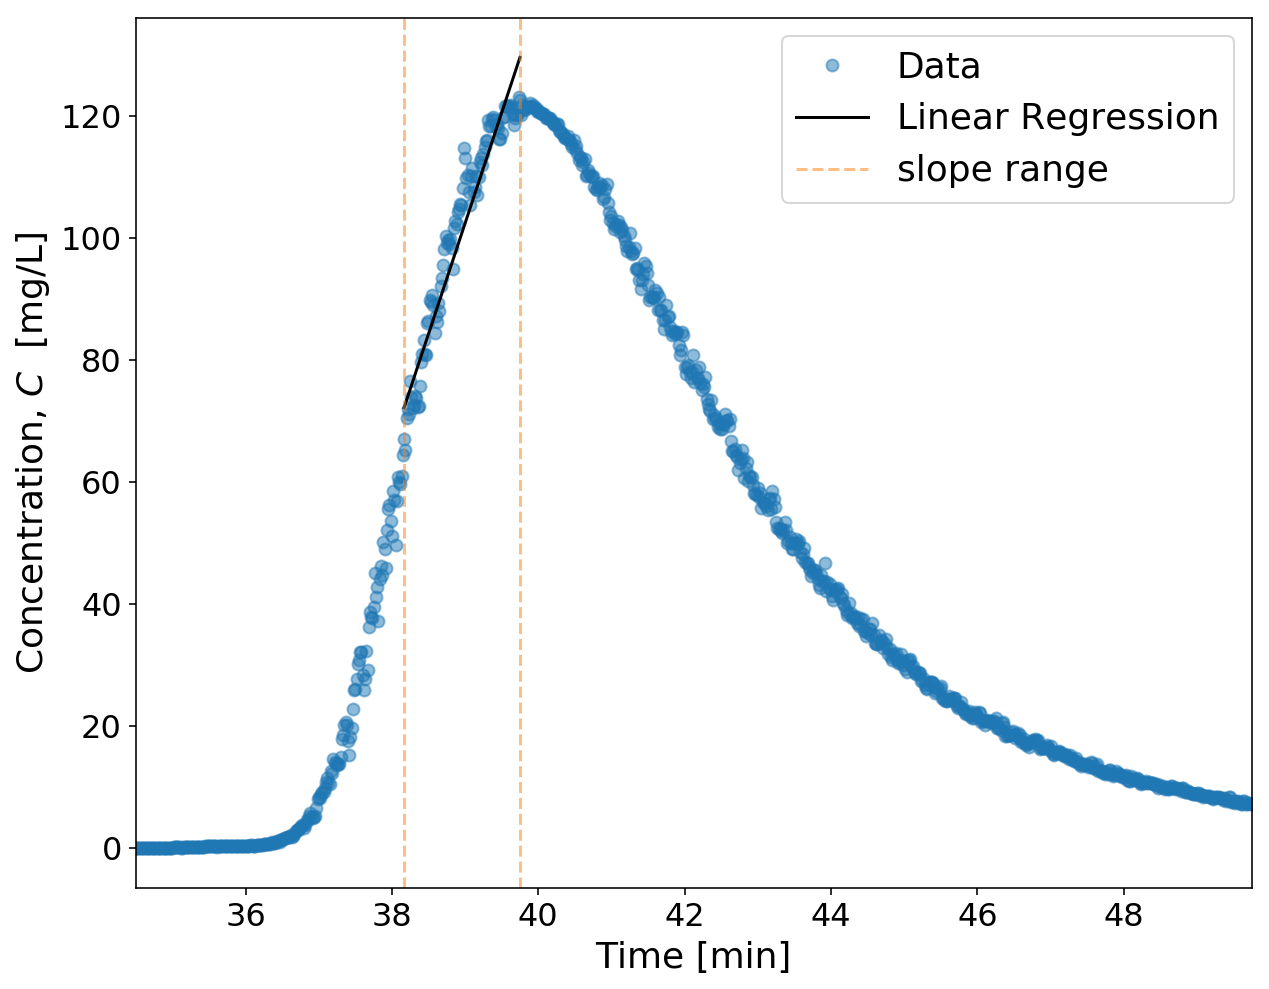

In [25]:
# set bounds on the leading front where where the slope will be calculated
ClowerD = 0.5
CupperD = 0.999

# calculate the slope of the leading front using data points near bounds
indx1 = nonzero(C_obs > ClowerD*Cmax)[0][0]
indx2 = nonzero(C_obs > CupperD*Cmax)[0][0]
t1 = t[indx1]
t2 = t[indx2]
dCdtmeas1 = (C_obs[indx2]-C_obs[indx1])/(t2-t1)

# select observed data between selected bounds
poop = np.where(np.logical_and(t>=t1, t<=t2))
Lt = t[poop]
LC = C_obs[poop]

# create separate dataframe for obs. data between bounds
datat=pd.DataFrame(Lt, columns=['t_sec'])
dataC=pd.DataFrame(LC, columns=['C_obs'])
result = pd.concat([datat, dataC], axis=1)

# calculate the slope of the leading front using linear regression between bounds
lm = smf.ols(formula='C_obs ~ t_sec', data=result).fit()

# slope of the leading front using linear regression between bounds
dCdtreg1 = lm.params.t_sec

# compute new conc valus with linear regression eqn.
C_hat = lm.predict(datat)

# plot linear regression line with observed data
fig, ax = plt.subplots()
ax.plot(data.t_sec/60,C_obs,'o', alpha = 0.5, label='Data')
ax.plot(datat/60, C_hat,'r', color='k', linestyle = '-', label = 'Linear Regression')

ax.axvline(x=t1/60,color='C1', linestyle='--', alpha=0.5, label='slope range')
ax.axvline(x=t2/60,color='C1', linestyle='--', alpha=0.5)
ax.set_xlabel('Time [min]', fontsize=18)
ax.set_ylabel('Concentration, $C$  [mg/L]', fontsize=18)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
legend(loc=1, prop={'size': 18})
ax.set_xlim(tstart/60-2,tpeak/60+10)

# save plot
fig.set_size_inches(10, 8, forward = True)
fig.savefig('illicit_reach4_obs.jpeg',bbox_inches='tight', dpi=100)

sloperange1= str(ClowerD) + 'Cmax and ' +str(CupperD) + 'Cmax'
print('-----------------------------------------------------')
print('Front slope between', sloperange1)
print('C=C(t) slope from data points =',around(dCdtmeas1,decimals=4))
print('C=C(t) slope from regression line =',around(dCdtreg1,decimals=4))

### Calculate distance upstream

#### Define Taylor solution

In [26]:
def taylorU(t,M,U,K,x):
    Cp = (M/(A*sqrt(4*pi*K*t)))*exp(-(x-U*t)**2/(4*K*t))
    return Cp # returns C in mg/L

#### Prepare variables for input into Taylor solution

In [27]:
# prepare/percolate values for the 'for' loop
N = 1000
xrange = linspace(1,1000,N) # synthetic distance 1 --> 1000 meters

dCdt = zeros(N) #synthetic slope using data point limits (Clower, Cupper)
dCdtregsyn = zeros(N) #synthetic regression line slope

# give variance (breathing room) to approximated mass
MMM = 50
Msyn = linspace(M-M*.35,M+M*.35,MMM) # +/- 35% of approximated mass
M_int = zeros(MMM)

# initial value of difference between syn. and obs. slopes, will be minimized
diffi = 10

#### Estimate $X_{start}$ using Taylor Solution
A synthetic concentration profile and a linear regression line (between the same bounds) is computed using the Taylor solution. A 'for' loop iterates a range of distances, $x$, and a selection of masses, $M$, into the Taylor solution. (The mass selection is +/- 35% the estimated mass from the area under the obs. conc. profile). The loop outputs an approximate distance to the source when the difference between the linear regression slopes of the obs. conc. and syn. conc. profiles is minimized. Program takes 10 minutes

In [28]:
## SLOPE D -------------(takes 7 minutes to run)----------------------------------------------
for i in range(1,N):
    for j in range(1,MMM):
        tend = 10*(xrange[i]/U)
        tsyn = linspace(1,tend, N)
        Csyn = taylorU(tsyn,Msyn[j],U,K,xrange[i])
        Cmax = amax(Csyn)
        #determine synthetic slope between selected limits
        indx1 = nonzero(Csyn > ClowerD*Cmax)[0][0]
        indx2 = nonzero(Csyn > CupperD*Cmax)[0][0]
        t1 = tsyn[indx1]
        t2 = tsyn[indx2]
        #determine synthetic slope of regression line between selected limits
        Srange = np.where(np.logical_and(tsyn>=t1, tsyn<=t2))
        #select synthetic data between selected lower and upper limits
        Ltsyn = tsyn[Srange]
        LCsyn = Csyn[Srange]
        #create separate synthetic dataframe for leading slope
        datatsyn=pd.DataFrame(Ltsyn, columns=['t_sec_syn'])
        dataCsyn=pd.DataFrame(LCsyn, columns=['C_mgL_syn'])
        resultsyn = pd.concat([datatsyn, dataCsyn], axis=1)
        #perform linear regression on synthetic data
        lmsyn = smf.ols(formula='C_mgL_syn ~ t_sec_syn', data=resultsyn).fit()
        #synthetic slope of synthetic regression line
        dCdtregsyn = lmsyn.params.t_sec_syn
        #run 'if' statement until diffi is minimized
        diff = (np.abs(dCdtregsyn-dCdtreg1))
        if diff < diffi:
            diffi = diff
            XYZ = xrange[i]
            MYZ = Msyn[j]
        
print('Approximate distance to upstream source (ft):', around(XYZ/ft_m, decimals = 0))
print('Approximate mass equivalent of NaCl (g):', around(MYZ, decimals = 0))

Approximate distance to upstream source (ft): 233.0
Approximate mass equivalent of NaCl (g): 585.0


#### Plot the Synthetic and Observed curves

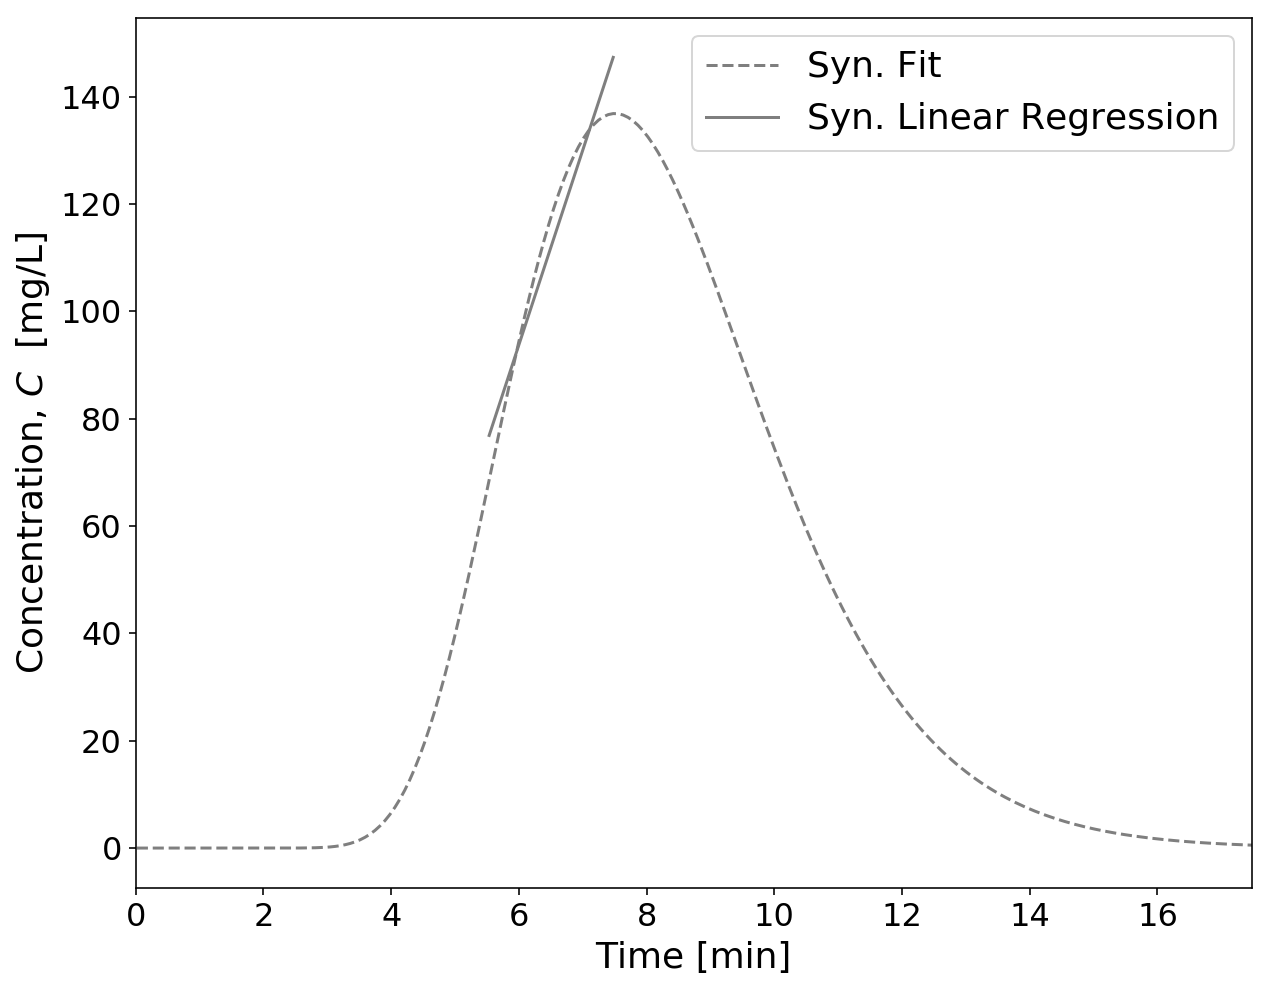

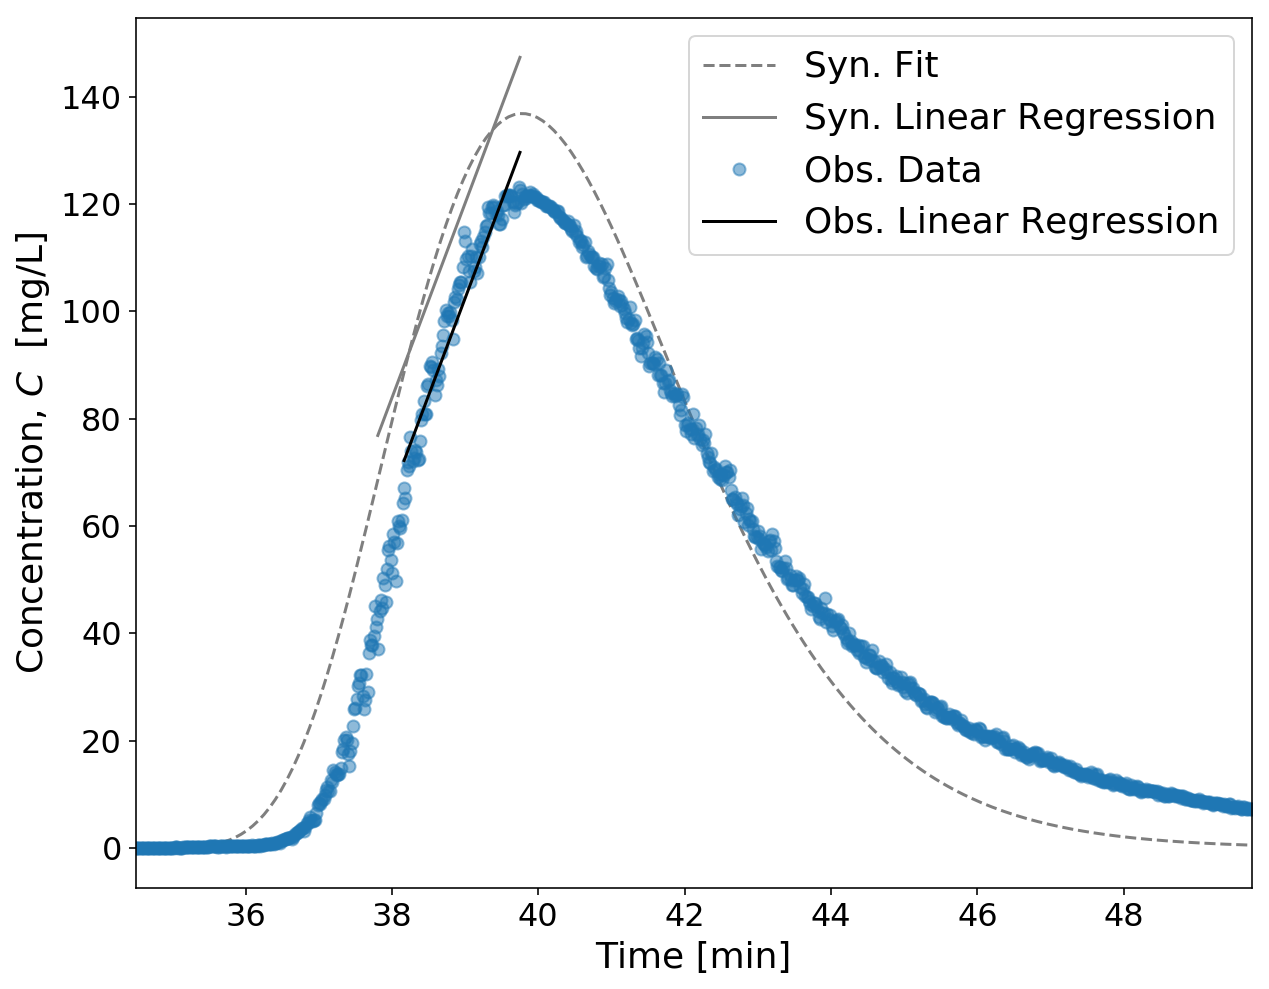

In [29]:
#---- Run Taylor Solution again with known MYZ and XYZ to get Csyn ----
tend = 10*(XYZ/U)
tsyn = linspace(1,tend, N)
Csyn = taylorU(tsyn,MYZ,U,K,XYZ) #synthetic concentration curve
Cmax = amax(Csyn)
#determine synthetic slope between selected limits
indx1 = nonzero(Csyn > ClowerD*Cmax)[0][0]
indx2 = nonzero(Csyn > CupperD*Cmax)[0][0]
t1 = tsyn[indx1]
t2 = tsyn[indx2]
#determine synthetic slope of regression line between selected limits
Srange = np.where(np.logical_and(tsyn>=t1, tsyn<=t2))
#select synthetic data between selected lower and upper limits
Ltsyn = tsyn[Srange]
LCsyn = Csyn[Srange]
#create separate synthetic dataframe for leading slope
datatsyn=pd.DataFrame(Ltsyn, columns=['t_sec_syn'])
dataCsyn=pd.DataFrame(LCsyn, columns=['C_mgL_syn'])
resultsyn = pd.concat([datatsyn, dataCsyn], axis=1)
#perform linear regression on synthetic data
lmsyn = smf.ols(formula='C_mgL_syn ~ t_sec_syn', data=resultsyn).fit()

# --------Match peaks of obs and syn to fit on same plot------------------------------------------------------
# match synthetic peak to observed peak
tstartsyn = tsyn[nonzero(Csyn > 0.01*Cmax)[0][0]] # time of start
tpeaksyn = tsyn[argmax(Csyn)] # time of the peak

# create separate time array for synthetic peak
tplot = zeros(len(tsyn))
for i in range(0,len(tsyn)):
    tplot[i] = tsyn[i]+abs(tpeak-tpeaksyn)

datatsynplot = zeros(len(Ltsyn))
for i in range(0, len(Ltsyn)):
    datatsynplot[i] = Ltsyn[i]+abs(tpeak-tpeaksyn)

# create regression lines from obs and syn
C_hat_syn = lmsyn.predict(datatsyn) # syn regression
C_hat = lm.predict(datat) # obs regression

#plot linear regression line with observed data
fig, ax = plt.subplots()
ax.plot(tsyn/60, Csyn, '--', color ='k', alpha = 0.5, label = 'Syn. Fit')
ax.plot(datatsyn/60, C_hat_syn,'r', color='tab:gray', linestyle = '-', label = 'Syn. Linear Regression')
ax.set_xlabel('Time [min]', fontsize=18)
ax.set_ylabel('Concentration, $C$  [mg/L]', fontsize=18)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
legend(loc=1, prop={'size': 18})
ax.set_xlim(0,tpeaksyn/60+10)
fig.set_size_inches(10, 8, forward = True)
fig.savefig('illicit_reach4_syn.jpeg',bbox_inches='tight', dpi=100)

fig, ax = plt.subplots()
ax.plot(tplot/60, Csyn, '--', color ='k', alpha = 0.5, label = 'Syn. Fit')
ax.plot(datatsynplot/60, C_hat_syn,'r', color='tab:gray', linestyle = '-', label = 'Syn. Linear Regression')
ax.plot(data.t_sec/60,C_obs,'o', alpha = 0.5, label='Obs. Data')
ax.plot(datat/60, C_hat,'r', color='k', linestyle = '-', label = 'Obs. Linear Regression')
ax.set_xlabel('Time [min]', fontsize=18)
ax.set_ylabel('Concentration, $C$  [mg/L]', fontsize=18)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
legend(loc=1, prop={'size': 18})
ax.set_xlim(tstart/60-2,tpeak/60+10)

fig.set_size_inches(10, 8, forward = True)
fig.savefig('illicit_reach4_both.jpeg',bbox_inches='tight', dpi=100)

#### Outputs

In [30]:
print('Approximate mass equivalent of NaCl (g):', around(MYZ, decimals = 0))
print('Time of peak (s):', around(tpeaksyn, decimals = 2))
print('Approximate distance to upstream source multiplying time of peak and velocity (ft):', around(U*tpeaksyn/ft_m))
print('Approximate distance to upstream source from Taylor solution (ft):', around(XYZ/ft_m, decimals = 0))

Approximate mass equivalent of NaCl (g): 585.0
Time of peak (s): 448.6
Approximate distance to upstream source multiplying time of peak and velocity (ft): 224.0
Approximate distance to upstream source from Taylor solution (ft): 233.0


### References

CRC Handbook of Chemistry, and Physics, Edited by William M. Haynes. Boca Raton, Florida: CRC Press, 2014. pg. 5-73 <br /><br />
Fischer, H. B. 1967. “The Mechanics of Dispersion in Natural Streams.” American Society of Civil Engineers, 25, No. 5, 62-68 <br /> <br />
French, Richard. 1985. “Open-channel hydraulics” McGrawhill, New York. ISSN/ISBN: 0-07-022134-0, 978-0. <br /> <br />
Iwasa, Y., & Shirou Aya, S. 1991. “Predicting longitudinal dispersion coefficeint in open-channel flows.” Proceedings of the International Symposium on Environmental Hydraulics 1, 505-510. <br /> <br />
Koussis, A. D. and Jośe Rodríguez-Mirasol. 1998. “Hydraulic Estimation of Dispersion Coefficient for Streams.” Journal of Hydraulic Engineering 124, no. 3:317-320 <br /><br />
Rieckermann J., M. Neumann, C. Ort, J. L. Huisman, and W. Gujer. 2005. “Dispersion coefficients of sewers from tracer experiments.” Water Science & Technology 52, no. 5:123-134 + appendix.<br /><br />
Rutherford, J. C. 1994. “River Mixing.” John Wiley and Sons Ltd, Chichester, England <br /><br />
Wallis, S. G., and J. R. Manson. 2004. “Methods for Predicting Dispersion Coefficients in Rivers.” Proceedings of the ICE - Water Management 157 (3): 131–41. doi:10.1680/wama.2004.157.3.131.
